In [57]:
from google.colab import drive
import pandas as pd

# Load the data
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/Shareddrives/CMPE 257 - BitSmart/data/BTC-USD5years.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Dropping NaN values
df.dropna(inplace=True)

# Add Moving Average for better result
df['MA7_Close'] = df['Close'].rolling(window=7).mean().fillna(method='bfill')

print(df.columns)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA7_Close'],
      dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume,MA7_Close
0,2019-05-09,5982.316406,6183.039063,5982.316406,6174.528809,6174.528809,16784645411,7249.288574
1,2019-05-10,6175.822754,6434.617676,6161.519043,6378.849121,6378.849121,19419875368,7249.288574
2,2019-05-11,6379.666992,7333.002930,6375.698730,7204.771484,7204.771484,28867562329,7249.288574
3,2019-05-12,7203.507324,7503.872070,6815.770996,6972.371582,6972.371582,27773333680,7249.288574
4,2019-05-13,6971.178223,8047.413086,6898.282227,7814.915039,7814.915039,28677672181,7249.288574


In [58]:
# Sort DataFrame by date
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

# Reindex the DataFrame to fill in any missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates, method='ffill')

# Reset index if necessary
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA7_Close
1821,2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048,61611.089844
1822,2024-05-04,62891.031250,64494.957031,62599.351563,63891.472656,63891.472656,20620477992,61678.565848
1823,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132813,64031.132813,18296164805,61809.694755
1824,2024-05-06,64038.312500,65494.902344,62746.238281,63161.949219,63161.949219,28697928697,61712.670201
1825,2024-05-07,63162.761719,64390.457031,62285.980469,62334.816406,62334.816406,25930730982,61955.236049


In [59]:
# Further preprocess for model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing set
features = df[['Open', 'High', 'Low', 'Volume', 'MA7_Close']]
target = df['Close']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=88)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for each model
param_grids = {
    "Linear Regression": {},
    "Ridge Regression": {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 200.0, 300.0, 400.0, 500.0]},
    "Lasso Regression": {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]},
    "Random Forest": {
        'n_estimators': [100, 200, 300, 500, 1000],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    }
}

# Function to perform Grid Search
def tune_model(model, param_grid, X_train, y_train):
    if param_grid:  # Only perform Grid Search if param_grid is not empty
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {type(model).__name__}: {grid_search.best_params_}")
        print(f"Best CV MSE for {type(model).__name__}: {-grid_search.best_score_}")
        return best_model
    else:
        model.fit(X_train, y_train)
        return model

# Function to evaluate multiple models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def evaluate_models(models, param_grids, X, y):
    results = {}
    for name, model in models.items():
        model_instance = model()
        param_grid = param_grids[name]
        best_model = tune_model(model_instance, param_grid, X, y)
        results[name] = best_model
    return results

In [60]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def linear_regression_factory():
  return LinearRegression()

def ridge_factory():
  return Ridge()

def lasso_factory():
  return Lasso(alpha=0.1, max_iter=10000, tol=0.01)

def random_forest_regressor_factory():
  return RandomForestRegressor(random_state=42)

def gradient_boosting_regressor_factory():
  return GradientBoostingRegressor(random_state=42)

# Models to evaluate
models = {
    "Linear Regression": linear_regression_factory,
    "Ridge Regression": ridge_factory,
    "Lasso Regression": lasso_factory,
    "Random Forest": random_forest_regressor_factory,
    "Gradient Boosting": gradient_boosting_regressor_factory
}

# Evaluate and find the best model using cross-validation
best_models = evaluate_models(models, param_grids, X_train_scaled, y_train)
best_model_name = min(best_models, key=lambda name: mean_squared_error(y_test, best_models[name].predict(X_test_scaled)))
selected_model = best_models[best_model_name]
print(f"Best model: {best_model_name}")


Best parameters for Ridge: {'alpha': 0.01}
Best CV MSE for Ridge: 213279.93330871043
Best parameters for Lasso: {'alpha': 50.0}
Best CV MSE for Lasso: 1377246.3338935995


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters for RandomForestRegressor: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE for RandomForestRegressor: 429460.00780336343
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV MSE for GradientBoostingRegressor: 412115.591730111
Best model: Ridge Regression


In [61]:
# Further preprocessing for future prediction
# Creating lag features for 7-day predictions
for shift in range(1, 8):
    df[f'lag_close_{shift}'] = df['Close'].shift(shift)

# Dropping rows with NaN values resulting from lag creation
df.dropna(inplace=True)

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate future target values
df['future_high'] = df['High'].rolling(window=7).max().shift(-7)  # Highest price in the next 7 days
df['future_low'] = df['Low'].rolling(window=7).min().shift(-7)    # Lowest price in the next 7 days
df['future_avg'] = df['Close'].rolling(window=7).mean().shift(-7) # Average closing price in the next 7 days
df['future_open'] = df['Open'].shift(-7)  # Open price of the 7th day from today
df['future_close'] = df['Close'].shift(-7)  # Close price of the 7th day from today

# Replace NaNs in future target values with the mean of their respective columns
df['future_high'].fillna(df['future_high'].mean(), inplace=True)
df['future_low'].fillna(df['future_low'].mean(), inplace=True)
df['future_avg'].fillna(df['future_avg'].mean(), inplace=True)
df['future_open'].fillna(df['future_open'].mean(), inplace=True)
df['future_close'].fillna(df['future_close'].mean(), inplace=True)

# Define features and targets
features = df[[f'lag_close_{shift}' for shift in range(1, 8)] + ['Volume']]
target_high = df['future_high']
target_low = df['future_low']
target_avg = df['future_avg']
target_open = df['future_open']
target_close = df['future_close']

# Splitting data into training and test sets
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(features, target_high, test_size=0.3, random_state=88)
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(features, target_low, test_size=0.3, random_state=88)
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(features, target_avg, test_size=0.3, random_state=88)
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(features, target_open, test_size=0.3, random_state=88)
X_train_close, X_test_close, y_train_close, y_test_close = train_test_split(features, target_close, test_size=0.3, random_state=88)

# Train models using the selected model
model_high = selected_model.fit(X_train_high, y_train_high)
model_low = selected_model.fit(X_train_low, y_train_low)
model_avg = selected_model.fit(X_train_avg, y_train_avg)
model_open = selected_model.fit(X_train_open, y_train_open)
model_close = selected_model.fit(X_train_close, y_train_close)

In [62]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA7_Close,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,future_high,future_low,future_avg,future_open,future_close
1821,2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048,61611.089844,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469,63419.140625,63755.320313,30160.093261,26371.718016,28355.606125,28419.007913,28446.920461
1822,2024-05-04,62891.031250,64494.957031,62599.351563,63891.472656,63891.472656,20620477992,61678.565848,62889.835938,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469,63419.140625,30160.093261,26371.718016,28355.606125,28419.007913,28446.920461
1823,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132813,64031.132813,18296164805,61809.694755,63891.472656,62889.835938,59123.433594,58254.011719,60636.855469,63841.121094,63113.230469,30160.093261,26371.718016,28355.606125,28419.007913,28446.920461
1824,2024-05-06,64038.312500,65494.902344,62746.238281,63161.949219,63161.949219,28697928697,61712.670201,64031.132813,63891.472656,62889.835938,59123.433594,58254.011719,60636.855469,63841.121094,30160.093261,26371.718016,28355.606125,28419.007913,28446.920461
1825,2024-05-07,63162.761719,64390.457031,62285.980469,62334.816406,62334.816406,25930730982,61955.236049,63161.949219,64031.132813,63891.472656,62889.835938,59123.433594,58254.011719,60636.855469,30160.093261,26371.718016,28355.606125,28419.007913,28446.920461


In [63]:
# Function for Date Selection and Prediction
def predict_for_selected_date(selected_date, data, model_high, model_low, model_avg):
    selected_date = pd.to_datetime(selected_date)
    if selected_date not in data['Date'].values:
        raise Exception("Selected date is not available in the dataset.")

    # Extract the record for the selected date
    selected_record = data[data['Date'] == selected_date]
    if selected_record.empty:
        raise Exception("No data available for the selected date.")


    # Prepare the feature vector
    feature_names = ['lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4',
                     'lag_close_5', 'lag_close_6', 'lag_close_7', 'Volume']
    feature_vector = selected_record[feature_names].values.reshape(1, -1)

    feature_vector_df = pd.DataFrame(feature_vector, columns=feature_names)

    # Make predictions
    predicted_high = model_high.predict(feature_vector_df)[0]
    predicted_low = model_low.predict(feature_vector_df)[0]
    predicted_avg = model_avg.predict(feature_vector_df)[0]


    return predicted_high, predicted_low, predicted_avg

In [64]:
# Example date to test
test_date = '2024-05-07'

# Call the prediction function
try:
    predictions = predict_for_selected_date(test_date, df, model_high, model_low, model_avg)
    predicted_high, predicted_low, predicted_avg = predictions
    print(f"Predictions for {test_date}:")
    print(f"Highest Price: {predicted_high}, Lowest Price: {predicted_low}, Average Closing Price: {predicted_avg}")
except Exception as e:
    print(e)

Predictions for 2024-05-07:
Highest Price: 62324.456133429776, Lowest Price: 62324.456133429776, Average Closing Price: 62324.456133429776


In [65]:
import numpy as np

def adjust_features(base_features, num_days=7, volatility=0.05):
    adjusted_features = []
    for i in range(num_days):
        adjustment = 1 + np.random.randn() * volatility
        new_features = base_features * adjustment
        adjusted_features.append(new_features)
    return adjusted_features

def predict_next_7_days(selected_date, data, model_open, model_high, model_low, model_close, model_avg):

    selected_date = pd.to_datetime(selected_date)
    prediction_results = []
    max_date_in_data = data['Date'].max()

    for i in range(1, 8):
        future_date = selected_date + pd.Timedelta(days=i)

        if future_date > max_date_in_data:
            # Adjust features for future predictions if beyond dataset
            last_features = data.iloc[-1][['lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4', 'lag_close_5', 'lag_close_6', 'lag_close_7', 'Volume']]
            adjusted_features = adjust_features(last_features, num_days=1, volatility=0.02)
        else:
            # Regular prediction logic
            record = data[data['Date'] == future_date]
            adjusted_features = record[['lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4', 'lag_close_5', 'lag_close_6', 'lag_close_7', 'Volume']].values.reshape(1, -1)

        feature_vector_df = pd.DataFrame(adjusted_features, columns=['lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4', 'lag_close_5', 'lag_close_6', 'lag_close_7', 'Volume'])

        predicted_open = model_open.predict(feature_vector_df)[0]
        predicted_high = model_high.predict(feature_vector_df)[0]
        predicted_low = model_low.predict(feature_vector_df)[0]
        predicted_close = model_close.predict(feature_vector_df)[0]
        predicted_avg = model_avg.predict(feature_vector_df)[0]

        prediction_results.append({
            'Date': future_date.strftime('%Y-%m-%d'),
            'Open': predicted_open,
            'High': predicted_high,
            'Low': predicted_low,
            'Close': predicted_close,
            'Avg': predicted_avg,
        })

    return prediction_results

In [66]:
# Example usage
selected_date = '2024-04-30'
try:
    predictions = predict_next_7_days(selected_date, df, model_open, model_high, model_low, model_close, model_avg)
    for day_prediction in predictions:
        print(day_prediction)
except Exception as e:
    print(e)

{'Date': '2024-05-01', 'Open': 60007.754685970285, 'High': 60007.754685970285, 'Low': 60007.754685970285, 'Close': 60007.754685970285, 'Avg': 60007.754685970285}
{'Date': '2024-05-02', 'Open': 57403.01141563993, 'High': 57403.01141563993, 'Low': 57403.01141563993, 'Close': 57403.01141563993, 'Avg': 57403.01141563993}
{'Date': '2024-05-03', 'Open': 58492.001669216195, 'High': 58492.001669216195, 'Low': 58492.001669216195, 'Close': 58492.001669216195, 'Avg': 58492.001669216195}
{'Date': '2024-05-04', 'Open': 61584.41166984584, 'High': 61584.41166984584, 'Low': 61584.41166984584, 'Close': 61584.41166984584, 'Avg': 61584.41166984584}
{'Date': '2024-05-05', 'Open': 62328.71301812502, 'High': 62328.71301812502, 'Low': 62328.71301812502, 'Close': 62328.71301812502, 'Avg': 62328.71301812502}
{'Date': '2024-05-06', 'Open': 62179.34170428087, 'High': 62179.34170428087, 'Low': 62179.34170428087, 'Close': 62179.34170428087, 'Avg': 62179.34170428087}
{'Date': '2024-05-07', 'Open': 62324.45613342977

In [67]:
from datetime import datetime
from joblib import dump, load

# Store trained model as a file
trained_models = {
    'open': model_open,
    'high': model_high,
    'low': model_low,
    'close': model_close,
    'average': model_avg,
}
file_name = f'bitsmart_model_{int(datetime.now().timestamp())}'
dump(trained_models, file_name)

['bitsmart_model_1716064410']

In [68]:
a = load(file_name)
a

{'open': Ridge(alpha=0.01),
 'high': Ridge(alpha=0.01),
 'low': Ridge(alpha=0.01),
 'close': Ridge(alpha=0.01),
 'average': Ridge(alpha=0.01)}

In [69]:
# Load trained model from a file
try:
    model_open_load, model_high_load, model_low_load, model_close_load, model_avg_load = load(file_name)
    predictions = predict_next_7_days(selected_date, df, model_open_load, model_high_load, model_low_load, model_close_load, model_avg_load)
    for day_prediction in predictions:
        print(day_prediction)
except Exception as e:
    print(e)

'str' object has no attribute 'predict'


In [70]:
def swing_trading_strategy(selected_date, data, model_high, model_low, model_avg, investment_amount):
    selected_date = pd.to_datetime(selected_date)
    last_possible_date = data['Date'].max()

    # Calculate how many days of data are available after the selected date
    available_days = (last_possible_date - selected_date).days + 1

    if available_days < 1:
        return "Selected date is not available or no data available after the selected date."

    # Determine the number of days to predict based on available data
    prediction_days = min(available_days, 7)

    # Initialize trading state
    initial_open_price = data.loc[data['Date'] == selected_date, 'Open'].values[0]
    bitcoins = investment_amount / initial_open_price
    cash = 0

    sell_executed = False
    load_executed = False
    sell_day = None
    load_day = None
    total_avg_closing_price = 0

    # Loop through available days to make predictions and decide on actions
    for i in range(prediction_days):
        prediction_date = selected_date + pd.Timedelta(days=i)
        predicted_high, predicted_low, predicted_avg = predict_for_selected_date(prediction_date, data, model_high, model_low, model_avg)

        # Accumulate average closing prices
        total_avg_closing_price += predicted_avg

        # Decide when to sell: if predicted high price is 5% higher than the open price
        if not sell_executed and predicted_high > initial_open_price * 1.05:
            sell_executed = True
            sell_day = prediction_date
            cash = bitcoins * predicted_high
            bitcoins = 0

        # Decide when to load: after selling, if the predicted low price is 5% lower
        if sell_executed and not load_executed and predicted_low < predicted_high * 0.95:
            if prediction_date != sell_day:  # Ensure not loading on the sell day
                load_executed = True
                load_day = prediction_date
                bitcoins = cash / predicted_low
                cash = 0

    # Calculate average closing price over the prediction period
    average_closing_price = total_avg_closing_price / prediction_days

    # Final valuation at the end of the prediction period or the last available day
    final_day = selected_date + pd.Timedelta(days=prediction_days-1)
    final_close_price = data.loc[data['Date'] == final_day, 'Close'].values[0]
    final_cash = cash if cash > 0 else bitcoins * final_close_price

    # Calculate profit/loss
    profit_loss = final_cash - investment_amount

    return {
        "profit_loss": profit_loss,
        "total_investment_amount": investment_amount,
        "total_exit_amount": final_cash,
        "average_closing_price": average_closing_price,
        "sell_day": sell_day,
        "load_day": load_day,
        "final_bitcoins": bitcoins if cash == 0 else 0
    }

amount = 100000
result = swing_trading_strategy(test_date, df, model_high, model_low, model_avg, amount)
print(result)

{'profit_loss': -1310.812400324401, 'total_investment_amount': 100000, 'total_exit_amount': 98689.1875996756, 'average_closing_price': 62324.456133429776, 'sell_day': None, 'load_day': None, 'final_bitcoins': 1.5832113301961428}


In [71]:
# The Swing Trading Strategy Function Greedy
def swing_trading_strategy(selected_date, data, model_high, model_low, model_avg):
    selected_date = pd.to_datetime(selected_date)
    last_possible_date = data['Date'].max()

    # Calculate how many days of data are available after the selected date
    available_days = (last_possible_date - selected_date).days + 1

    if available_days < 1:
        return "Selected date is not available or no data available after the selected date."

    # Determine the number of days to predict based on available data
    prediction_days = min(available_days, 7)

    # Initialize trading state
    initial_open_price = data.loc[data['Date'] == selected_date, 'Open'].values[0]
    bitcoins = 100000 / initial_open_price
    cash = 0

    sell_executed = False
    load_executed = False
    sell_day = None
    load_day = None

    # Loop through available days to make predictions and decide on actions
    for i in range(prediction_days):
        prediction_date = selected_date + pd.Timedelta(days=i)
        predicted_high, predicted_low, predicted_avg = predict_for_selected_date(prediction_date, data, model_high, model_low, model_avg)
        print(f'{prediction_date}, {predicted_high}, {predicted_low}, {predicted_avg}')

        # Decide when to sell: if predicted high price is 15% higher than the open price
        if not sell_executed and predicted_high > initial_open_price * 1.15:
            sell_executed = True
            sell_day = prediction_date
            cash = bitcoins * predicted_high
            bitcoins = 0

        # Decide when to load: after selling, if the predicted low price is 15% lower
        if sell_executed and not load_executed and predicted_low < predicted_high * 0.85:
            if prediction_date != sell_day:  # Ensure not loading on the sell day
                load_executed = True
                load_day = prediction_date
                bitcoins = cash / predicted_low
                cash = 0

    # Final valuation at the end of the prediction period or the last available day
    final_day = selected_date + pd.Timedelta(days=prediction_days-1)
    final_close_price = data.loc[data['Date'] == final_day, 'Close'].values[0]
    final_cash = cash if cash > 0 else bitcoins * final_close_price

    return {
        "sell_day": sell_day,
        "load_day": load_day,
        "final_cash": final_cash,
        "final_bitcoins": bitcoins if cash == 0 else 0,
        "final_value": final_cash
    }


result = swing_trading_strategy(test_date, df, model_high, model_low, model_avg)
print(result)

2024-05-07 00:00:00, 62324.456133429776, 62324.456133429776, 62324.456133429776
{'sell_day': None, 'load_day': None, 'final_cash': 98689.1875996756, 'final_bitcoins': 1.5832113301961428, 'final_value': 98689.1875996756}


In [72]:
#Evaluate Training Performance

import pandas as pd
import matplotlib.pyplot as plt

# Function to evaluate model performance on training data
def evaluate_training_performance(model, X_train, y_train, model_name):
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    print(f'Training MSE for {model_name}: {mse}')
    return mse

# Evaluate training performance for each model
X_train_features = df[[f'lag_close_{shift}' for shift in range(1, 8)] + ['Volume']]
y_train_open = df['future_open']
y_train_high = df['future_high']
y_train_low = df['future_low']
y_train_avg = df['future_avg']
y_train_close = df['future_close']

evaluate_training_performance(model_open, X_train_features, y_train_open, 'Open Price')
evaluate_training_performance(model_high, X_train_features, y_train_high, 'High Price')
evaluate_training_performance(model_low, X_train_features, y_train_low, 'Low Price')
evaluate_training_performance(model_avg, X_train_features, y_train_avg, 'Average Price')
evaluate_training_performance(model_close, X_train_features, y_train_close, 'Close Price')

Training MSE for Open Price: 13277053.017719988
Training MSE for High Price: 14978702.461578952
Training MSE for Low Price: 15175741.290020436
Training MSE for Average Price: 9154289.238656545
Training MSE for Close Price: 14611034.784556212


14611034.784556212

In [73]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Function to perform cross-validation
def cross_validate_model(model, X, y, model_name, cv=5):
    tscv = TimeSeriesSplit(n_splits=cv)
    mse_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores  # Convert to positive MSE
    print(f'Cross-Validation MSE Scores for {model_name}: {mse_scores}')
    print(f'Average CV MSE for {model_name}: {mse_scores.mean()}')
    return mse_scores

# Cross-validate each model
cross_validate_model(model_open, X_train_features, y_train_open, 'Open Price')
cross_validate_model(model_high, X_train_features, y_train_high, 'High Price')
cross_validate_model(model_low, X_train_features, y_train_low, 'Low Price')
cross_validate_model(model_avg, X_train_features, y_train_avg, 'Average Price')
cross_validate_model(model_close, X_train_features, y_train_close, 'Close Price')

Cross-Validation MSE Scores for Open Price: [ 9672913.06913614 61604551.32963879 12761414.40495547  2766151.98307969
 35759254.55350929]
Average CV MSE for Open Price: 24512857.068063878
Cross-Validation MSE Scores for High Price: [ 6194139.64661619 48573975.50686537  6472213.10941224  2334494.03529712
 36339847.79502629]
Average CV MSE for High Price: 19982934.018643443
Cross-Validation MSE Scores for Low Price: [ 3305140.16392948 21464287.71519605  8805729.7642658   1522301.89650458
 26864220.70642286]
Average CV MSE for Low Price: 12392336.049263753
Cross-Validation MSE Scores for Average Price: [ 4949783.94413221 32182837.71630663  6971777.1141336   1507125.03156709
 31056566.73322295]
Average CV MSE for Average Price: 15333618.107872497
Cross-Validation MSE Scores for Close Price: [12240552.23756509 75413530.97344072 14398067.22954495  3240371.60284051
 37514166.69372475]
Average CV MSE for Close Price: 28561337.7474232


array([12240552.23756509, 75413530.97344072, 14398067.22954495,
        3240371.60284051, 37514166.69372475])

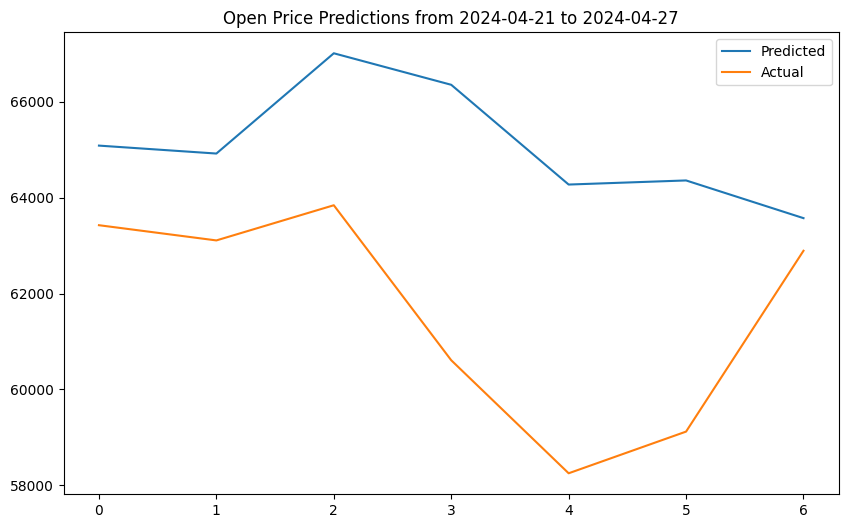

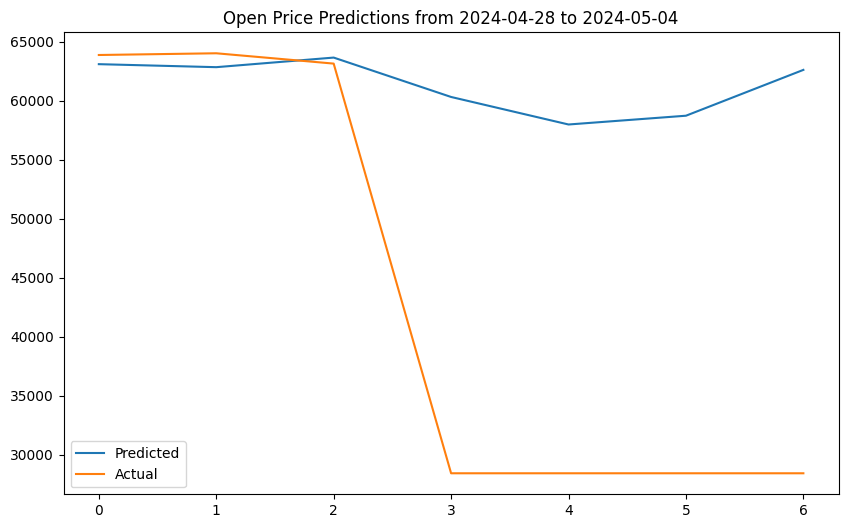

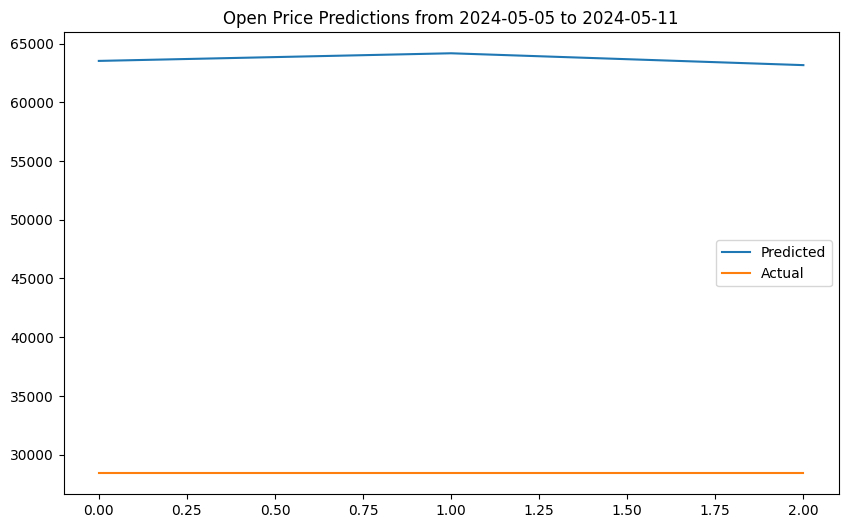

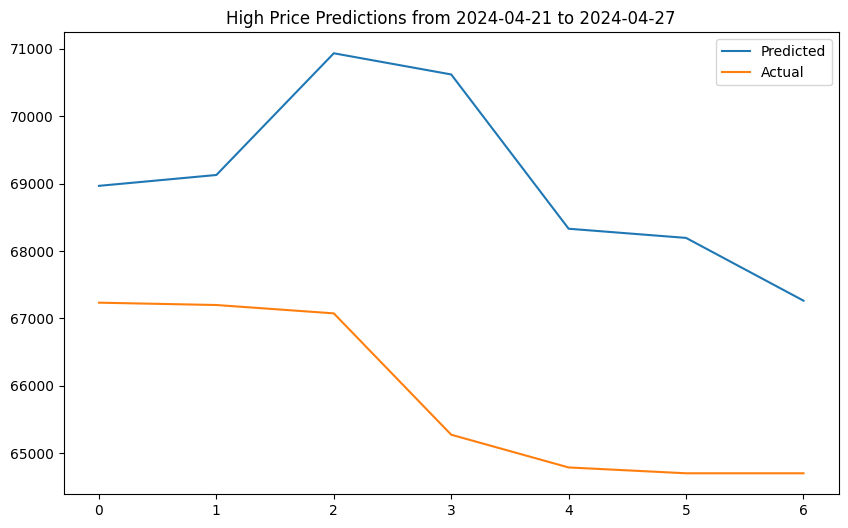

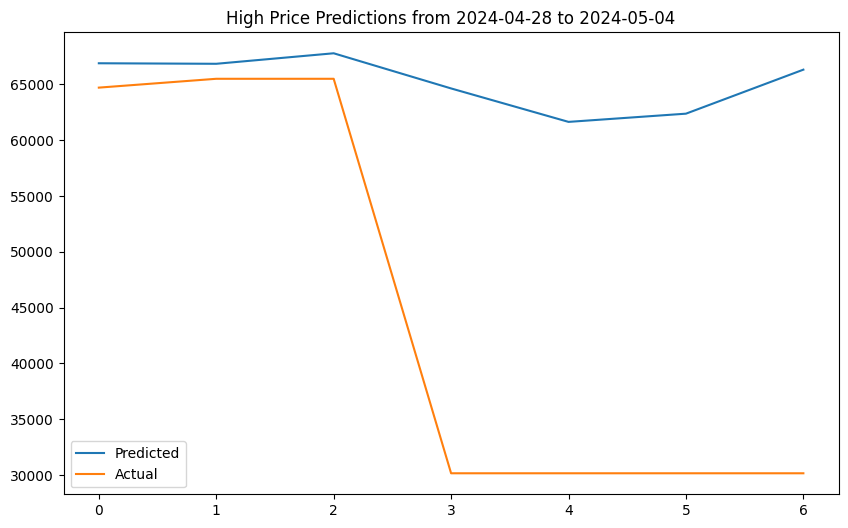

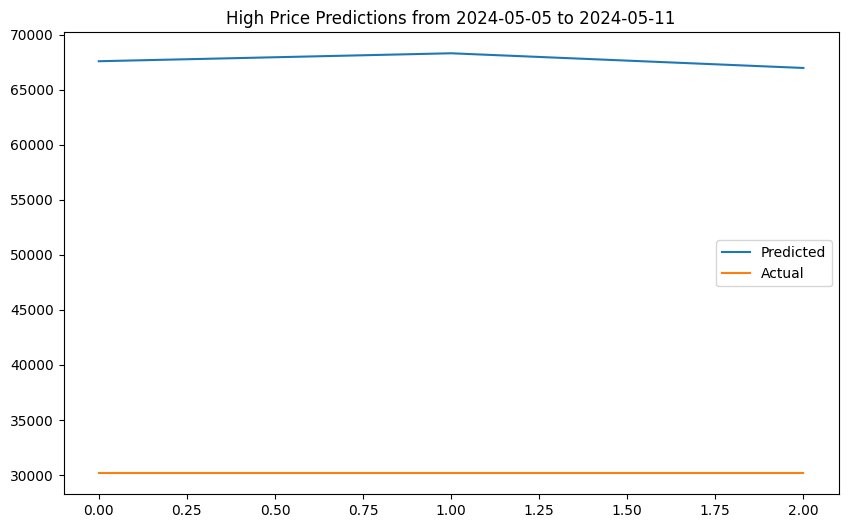

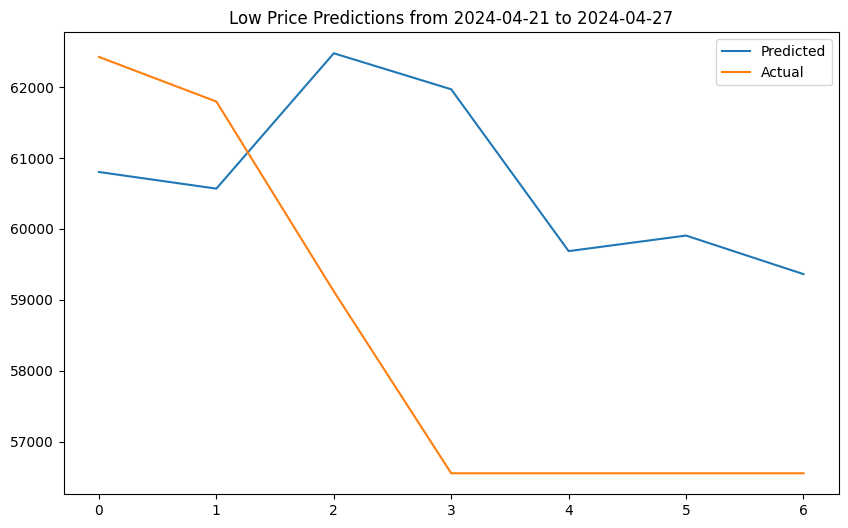

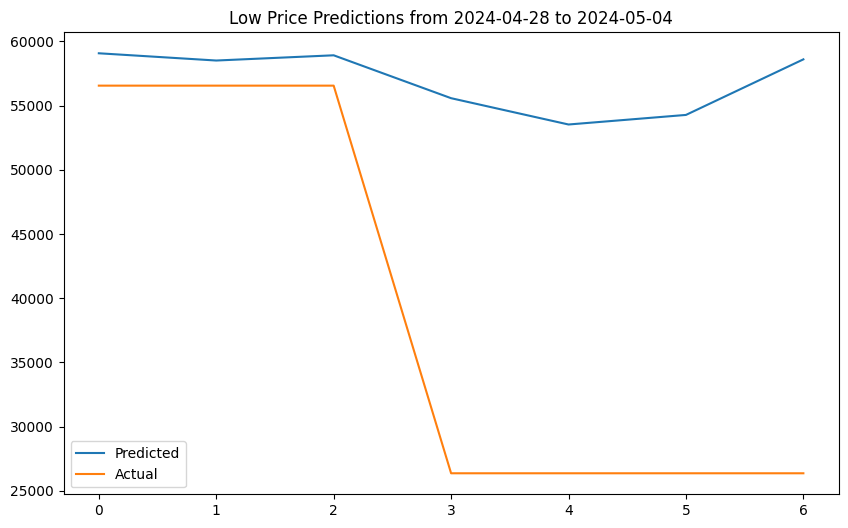

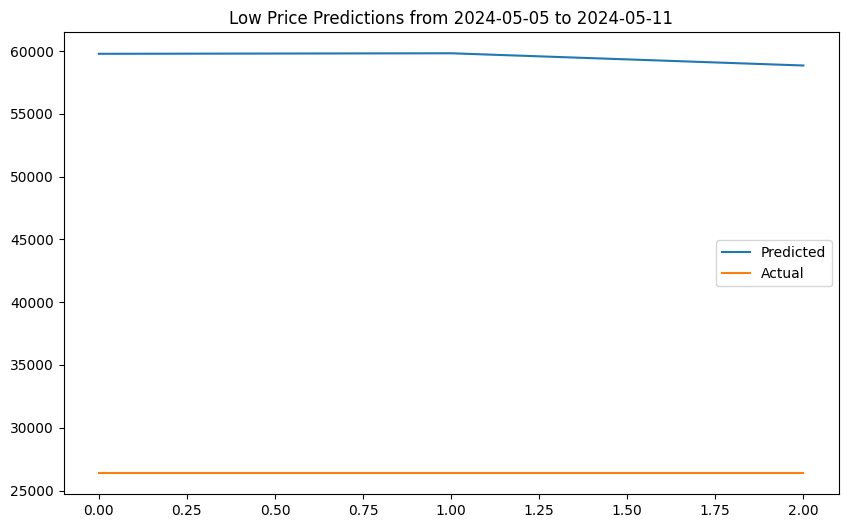

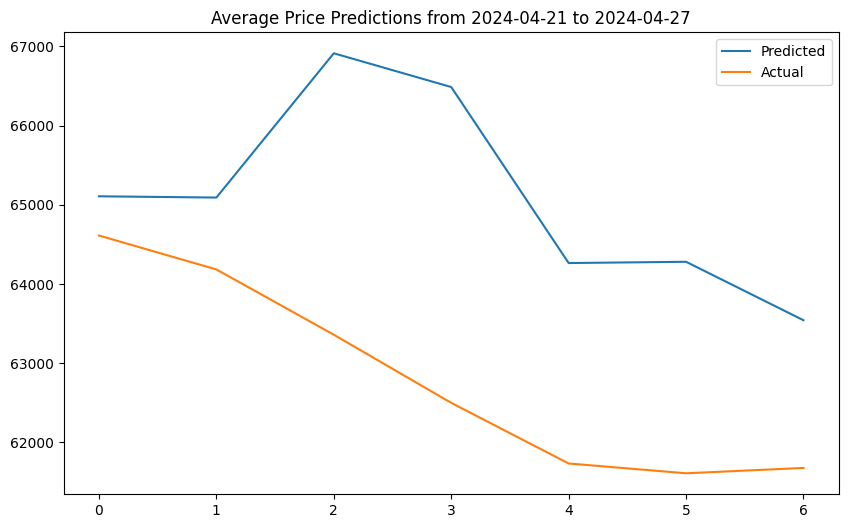

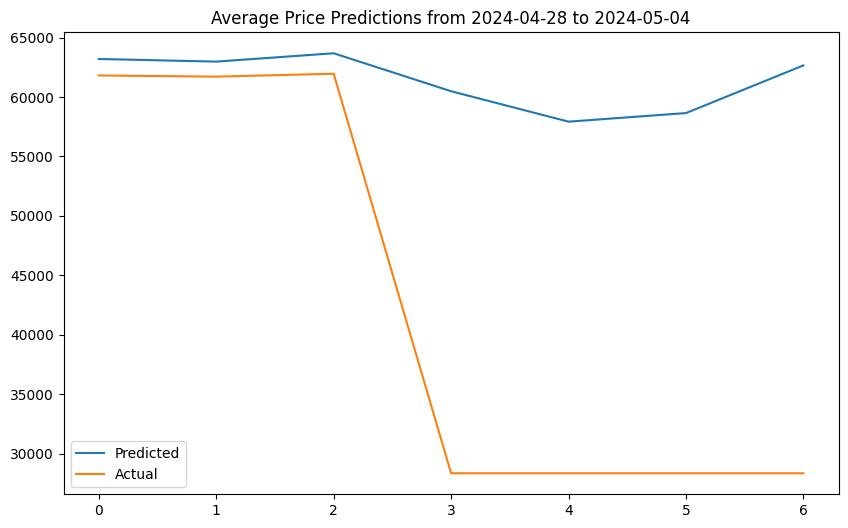

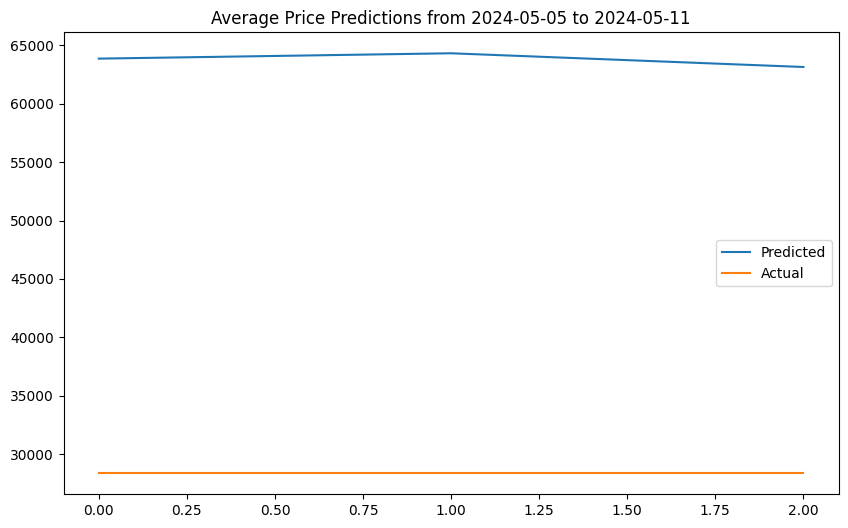

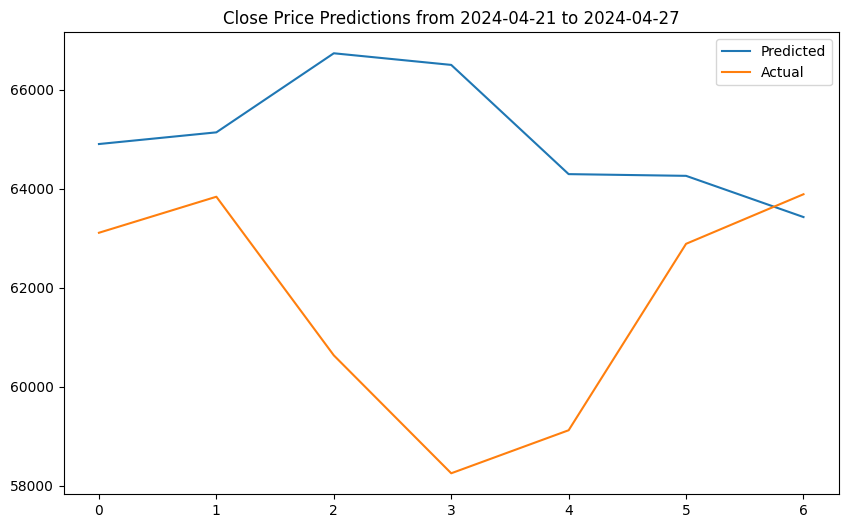

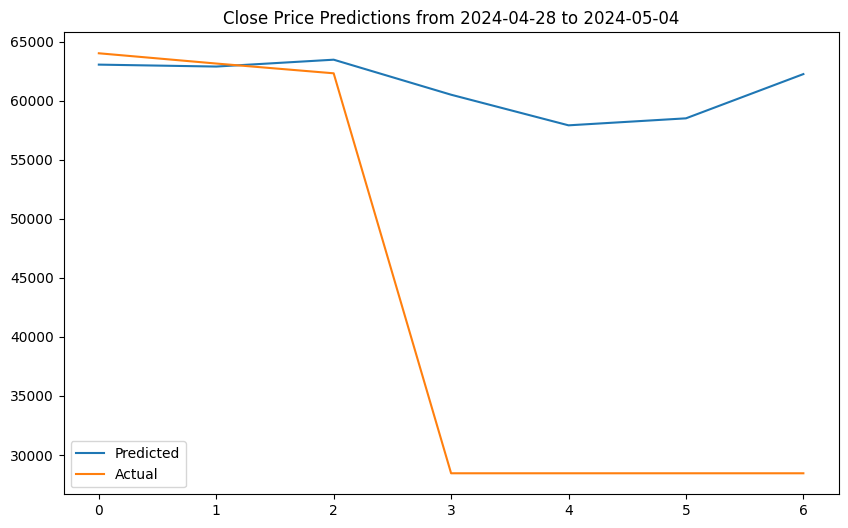

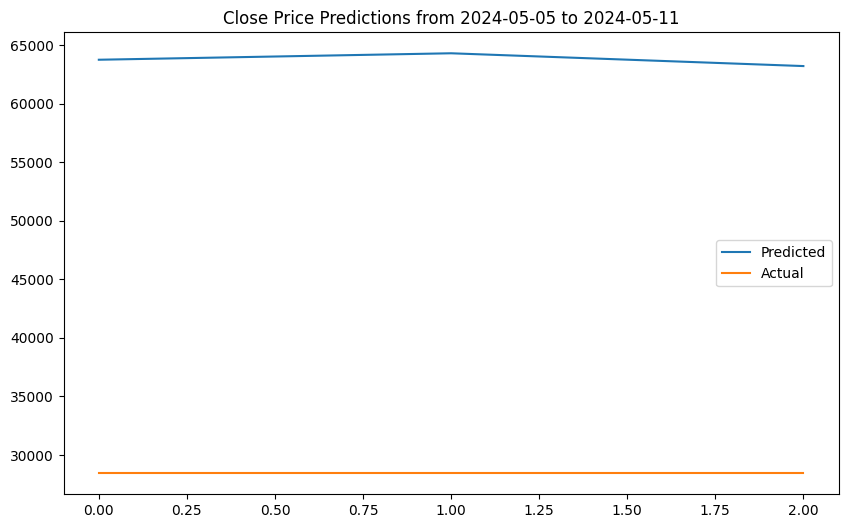

In [74]:
def backtest_model(model, data, feature_columns, target_column, start_date, end_date, prediction_days=7):
    results = []
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    prediction_results = []

    while current_date <= end_date:
        # Define the training period and the prediction period
        train_end_date = current_date - pd.Timedelta(days=1)
        prediction_start_date = current_date
        prediction_end_date = current_date + pd.Timedelta(days=prediction_days-1)

        # Training data
        train_data = data[data['Date'] <= train_end_date]
        X_train = train_data[feature_columns]
        y_train = train_data[target_column]

        # Fit model
        model.fit(X_train, y_train)

        # Prediction data
        prediction_data = data[(data['Date'] >= prediction_start_date) & (data['Date'] <= prediction_end_date)]
        if not prediction_data.empty:
            X_pred = prediction_data[feature_columns]
            predictions = model.predict(X_pred)
            prediction_results.append({
                'prediction_start_date': prediction_start_date,
                'prediction_end_date': prediction_end_date,
                'predictions': predictions,
                'actuals': prediction_data[target_column].values
            })

        # Move to the next prediction period
        current_date += pd.Timedelta(days=prediction_days)

    return prediction_results

# Backtesting parameters
start_date = '2024-04-21'
end_date = '2024-05-05'
feature_columns = [f'lag_close_{shift}' for shift in range(1, 8)] + ['Volume']

# Backtest each model
backtest_results_open = backtest_model(model_open, df, feature_columns, 'future_open', start_date, end_date)
backtest_results_high = backtest_model(model_high, df, feature_columns, 'future_high', start_date, end_date)
backtest_results_low = backtest_model(model_low, df, feature_columns, 'future_low', start_date, end_date)
backtest_results_avg = backtest_model(model_avg, df, feature_columns, 'future_avg', start_date, end_date)
backtest_results_close = backtest_model(model_close, df, feature_columns, 'future_close', start_date, end_date)

# Visualize backtesting results
def plot_backtesting_results(results, title):
    for result in results:
        plt.figure(figsize=(10, 6))
        plt.plot(result['predictions'], label='Predicted')
        plt.plot(result['actuals'], label='Actual')
        plt.title(f'{title} from {result["prediction_start_date"].date()} to {result["prediction_end_date"].date()}')
        plt.legend()
        plt.show()

plot_backtesting_results(backtest_results_open, 'Open Price Predictions')
plot_backtesting_results(backtest_results_high, 'High Price Predictions')
plot_backtesting_results(backtest_results_low, 'Low Price Predictions')
plot_backtesting_results(backtest_results_avg, 'Average Price Predictions')
plot_backtesting_results(backtest_results_close, 'Close Price Predictions')